In [1]:
import duckdb
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())


In [2]:
# function to query sakila
def query_sakila(query: str, duckdb_path="data/sakila.duckdb"):
    with duckdb.connect(duckdb_path) as conn:
        df = conn.sql(query=query).df()

    return df

## a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [3]:
query_sakila("""
SELECT
    title,
    length
FROM film
WHERE length > 180
ORDER BY length;
""").head()

,title,length
0,LAWLESS VISION,181
1,WILD APOLLO,181
2,STAR OPERATION,181
3,RUNAWAY TENENBAUMS,181
4,ANALYZE HOOSIERS,181


b) Which movies have the word "love" in its title? Show the following columns
- title
- rating
- length
- description

In [4]:
query_sakila("""
SELECT
    title,
    rating,
    length,
    description
FROM film
WHERE title ILIKE '%love%';
""")

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


In [5]:
query_sakila("""
    SELECT
    title,
    rating,
    length,
    description
FROM film
WHERE regexp_matches(title, '\\blove\\b', 'i'); 
""")
#\\blove\\b LLM generated because the \b we used during one of the lessons didn't work, 
# acording to chatgpt: '\\b' is needed because Python escapes backslashes; this sends '\b' to Postgres.

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


## c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and
## longest movie length


In [6]:

query_sakila("""
SELECT
    MIN(length) AS shortest,
    AVG(length) AS average,
    MEDIAN(length) as median,
    MAX(length) AS longest
FROM film;
""")

,shortest,average,median,longest
0,46,115.272,114.0,185


## d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can
## keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.


In [17]:
query_sakila("""
SELECT
    title,
    rental_rate,
    rental_duration,
    rental_rate / rental_duration AS cost_per_day
FROM film
ORDER BY cost_per_day DESC;
""").head(10)

,title,rental_rate,rental_duration,cost_per_day
0,PATHS CONTROL,4.99,3,1.663333
1,BACKLASH UNDEFEATED,4.99,3,1.663333
2,BEHAVIOR RUNAWAY,4.99,3,1.663333
3,VIRTUAL SPOILERS,4.99,3,1.663333
4,TEEN APOLLO,4.99,3,1.663333
5,TELEGRAPH VOYAGE,4.99,3,1.663333
6,BILKO ANONYMOUS,4.99,3,1.663333
7,HEARTBREAKERS BRIGHT,4.99,3,1.663333
8,CLERKS ANGELS,4.99,3,1.663333
9,TIES HUNGER,4.99,3,1.663333


## e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have
## played in.


In [8]:
query_sakila("""
SELECT
    a.first_name || ' ' || a.last_name AS actor_name,
    COUNT(f.film_id) AS film_count
FROM actor a
    JOIN film_actor fa ON fa.actor_id = a.actor_id
    JOIN film f ON f.film_id = fa.film_id
GROUP BY actor_name
ORDER BY film_count DESC LIMIT 10;
""")



,actor_name,film_count
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,UMA WOOD,35
8,ANGELA WITHERSPOON,35
9,GROUCHO DUNST,35


## f) Now it's time for you to choose your own question to explore the sakila database! Write down 3-5
## questions you want to answer and then answer them using pandas and duckdb.


Which country has the most amount of customers in the sakila database?

In [9]:
query_sakila("""
SELECT
    co.country,
    COUNT(c.customer_id) AS customer_count
FROM customer c
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY co.country
ORDER BY customer_count DESC;
""").head(10)

,country,customer_count
0,India,60
1,China,53
2,United States,36
3,Japan,31
4,Mexico,30
5,Russian Federation,28
6,Brazil,28
7,Philippines,20
8,Turkey,15
9,Indonesia,14


Is there an actor whose first name starts with A, last name starts with B that acts in a movie with title starting with the letter C? ABC :)

In [10]:
query_sakila("""
SELECT
    a.first_name,
    a.last_name,
    f.title
FROM film f
JOIN film_actor fa on fa.film_id = f.film_id
JOIN actor a on a.actor_id = fa.actor_id
WHERE a.first_name ILIKE 'A%' and a.last_name ILIKE 'B%' and f.title ILIKE 'C%';
""")

,first_name,last_name,title
0,AUDREY,BAILEY,CONFESSIONS MAGUIRE


Which employee has earned the most amount of money?

In [11]:
query_sakila("""
SELECT
    s.first_name || ' ' || s.last_name as employee,
    SUM(p.amount) as total_amount
FROM staff s
JOIN payment p on s.staff_id = p.staff_id
GROUP BY 
    s.first_name,
    s.last_name,
    s.active
ORDER BY total_amount DESC;
""")

,employee,total_amount
0,Jon Stephens,33927.04
1,Mike Hillyer,33489.47


## Task 2 - graphs

## a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them
## with special offers. Create a bar chart showing the top 5 customers by total spend.

In [12]:
customers_spend = query_sakila("""
SELECT
    c.first_name || ' ' || c.last_name AS customer_name,
    SUM(p.amount) AS total_spend
FROM customer c
JOIN payment p ON p.customer_id = c.customer_id
GROUP BY customer_name
ORDER BY total_spend DESC;
""")

customers_spend.head()

,customer_name,total_spend
0,KARL SEAL,221.55
1,ELEANOR HUNT,216.54
2,CLARA SHAW,195.58
3,MARION SNYDER,194.61
4,RHONDA KENNEDY,194.61


<Axes: title={'center': 'Top 5 customers'}, xlabel='customer', ylabel='amount spent'>

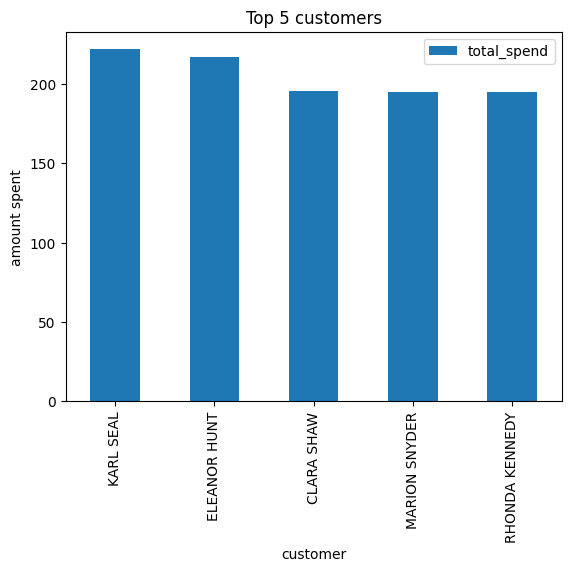

In [19]:
ax = customers_spend.head().plot(
    kind="bar",
    x="customer_name",
    y="total_spend",
    title="Top 5 customers",
    ylabel="amount spent",
    xlabel="customer",
)

ax

## b) How much money does each film category bring in? Make a bar chart showing total revenue per film
## category

Hint: join category -> film_category -> film -> inventory -> rental ->
payment

In [14]:
film_category_earnings = query_sakila("""
SELECT
    c.name AS category,
    SUM(p.amount) AS earnings
FROM category c
JOIN film_category fc ON fc.category_id = c.category_id
JOIN film f ON f.film_id = fc.film_id
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON r.inventory_id = i.inventory_id
JOIN payment p ON p.rental_id = r.rental_id
GROUP BY category
ORDER BY earnings DESC;
""")

film_category_earnings.head()

,category,earnings
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58


<Axes: title={'center': 'Revenue per film category'}, ylabel='category'>

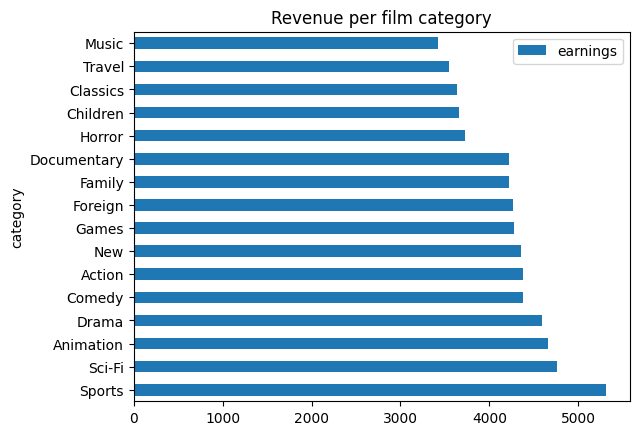

In [15]:
ax = film_category_earnings.plot(
    kind="barh",
    x="category",
    y="earnings",
    title="Revenue per film category",
)

ax